In [29]:
# imports
import hmmlearn
from hmmlearn import hmm
from hmmlearn import vhmm
import numpy as np
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import pickle
import seaborn as sns
from datetime import datetime

# Reading in the data

In [6]:
# setting up global data variables
raw_df = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)
raw_df.columns
all_columns = ['400126', '400176', '400691', '401242', '401698',
       '405602']

Below we create a class for dealing with Data objects. We include attributes like the columns of data we care about, whether or not to normalize the data, a dataframe representation of the data as well as an array representation of the data. We include the split_data() method to split the data into a training and testing set. For a given train-test split ratio, we decide to deterministically split the data so that all flows up to a single time X are training, and all flows after X are testing. This is because the sequence of the data over time matters to us, as we are learning time series data. We also include a method plot_flow_correlations() to plot the flow correlations between the columns (road segments) of data. 

In our initialization, our method for normalization is as follows. We normalize across all flows for a given time of the day by essentially replacing the flows with their z-scores (subtracting the mean and dividing by the standard deviation of flows). This removes the periodicity of the data and effectively the effect of the time of day on the traffic dynamics, and we hope to analyze model predictive and/or forecasting performance when trained on unnormalized v. normalized data. Our intuition is that normalizing data might not actually improve performance, as the raw amount of flow at any given moment (and perhaps flow in a few previous timesteps) is really what contributes to the next few timesteps of traffic flow, not the amount of flow relative to the overall flows at that time of the day.

In [7]:
class Data():
    def __init__(self, columns, normalize=True):
        self.columns = columns
        self.normalize = normalize
        
        raw_df = pd.read_csv('~/UROP_transportation/data/I80_density.csv').dropna(axis=0)

        if normalize: # normalize data
            time_cache = {}
            for date in raw_df['Unnamed: 0']:
                time = date[-8:]
                if time not in time_cache:
                    mask = raw_df['Unnamed: 0'].str.contains(time)
                    same_time_df = raw_df[mask]
                    for column in self.columns:
                        # Calculate mean and standard deviation of the filtered values
                        mean_value = same_time_df[column].mean()
                        std_value = same_time_df[column].std()
                        # Apply z-score normalization to the 'Column' using the mean and standard deviation
                        normalized_values = (same_time_df[column] - mean_value) / std_value
                        # Assign the normalized values back to the DataFrame
                        raw_df.loc[raw_df['Unnamed: 0'].str.contains(time), column] = normalized_values
                time_cache[time] = 1

        self.dataframe = raw_df[columns]
        self.array = np.array(self.dataframe)

    def split_data(self, split):
        n_samples = self.array.shape[0]
        n_features = self.array.shape[1]

        num_training_points = math.floor(n_samples * split)
        self.training = self.array[0:num_training_points]
        self.testing = self.array[num_training_points:]
        
    def plot_flow_correlations(self):
        fig, ax = plt.subplots(figsize=(8,8))
        heatmap = ax.imshow(self.dataframe.corr())
        ax.set(xticks=[], yticks=[]);
        cbar = fig.colorbar(heatmap, ax=ax, shrink=0.8)
        plt.title('Segment Travel Time Correlations')
        plt.show()

# correlation heatmaps

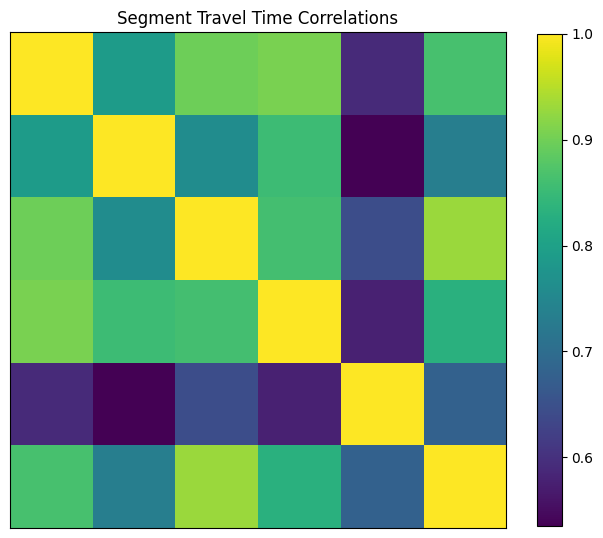

In [8]:
periodic_data = Data(columns = all_columns, normalize=False)
periodic_data.plot_flow_correlations()

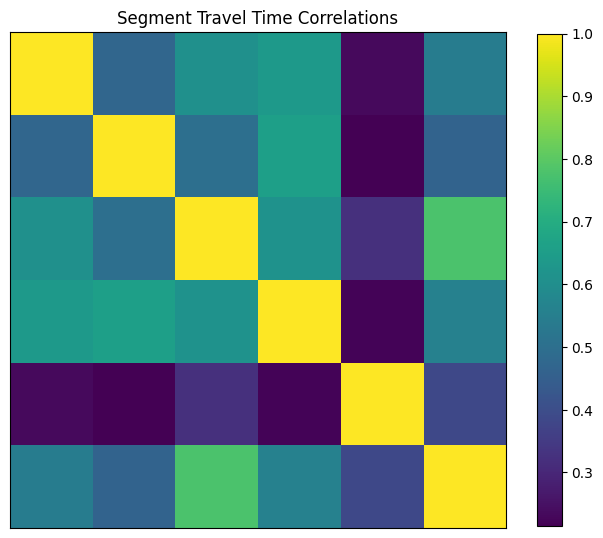

In [10]:
aperiodic_data = Data(columns = all_columns, normalize=True)
aperiodic_data.plot_flow_correlations()

# Setting up architecture

We set up a Hidden Markov model with a multivariate Gaussian emission function. The latent variable here are the states of the underlying Markov chain, which could possibly encode incidents. Right now I don't expect the model to work super well, because in the HMM, the observed (emission) traffic flows do not depend on each other, only on the underlying state of traffic, which in turn only depends on the previous traffic state. Perhaps for n segments of roads, O(n!) states would be sufficient for capturing relative order of traffic flows. Perhaps Gaussian emissions also doesn't make much sense with a discrete set of hidden states. Thus we will look into coding up a Linear Dynamical System (LDS) to capture continuous hidden states (with linear evolution + small Gaussian noise), and ideally the traffic flow emissions from continuous hidden states makes more sense. 

One downside to encoding traffic states as hidden states is that the model is less interpretable - it is unclear what kinds of states these traffic states are referring to, and we need many in order to get a reasonable accuracy. If we include certain latent variables encoding incidents into the hidden states, again it's not clear what our underlying structure between incidents and non-incidents should be.

In [12]:
# define custom type class VHMM model - each object is a model tied together with training data, testing data, predictions, etc.
# convenient to couple together model with associated scores/datasets/predictions

# design choices: 
    # want to keep passing in training_data and testing_data directly
    # rather than including methods for processing and splitting gtraining data, 
    # because potentially want to test on data from a different dataset (i.e. incidents)

class VHMM_Model():
    def __init__(self, num_components, covar_type, training_data=None, testing_data=None):
        """num_components: int, numbre of components
        covar_type: str, covariance type for model
        training and testing data: np.array types """
        self.num_components = num_components
        self.covar_type = covar_type
        self.training_data = training_data
        self.testing_data = testing_data
        self.n_samples = len(training_data) + len(testing_data)
        self.model = hmmlearn.vhmm.VariationalGaussianHMM(n_components=self.num_components, covariance_type=self.covar_type)
        self.score = None
        self.predicted_states_training = None
        self.predicted_states_testing = None
        self.predicted_flows_training = None
        self.predicted_flows_testing = None
        
    def train_model(self):
        converged = False
        while not converged:
            (self.model).fit(self.training_data, [len(self.training_data)])
            converged = (self.model).monitor_.converged
            if converged == False:
                print(f'model not converging for for num_components = {self.num_components}')
        return self.model
    
    def compute_score(self):
        self.score = (self.model).score(self.testing_data, [len(self.testing_data)])    
        return self.score
    
    def predict_states_and_flows(self):
        # self.model.means_ = list of means of gaussian emissions, indexed by state number
        self.predicted_states_training = self.model.predict(self.training_data, [len(self.training_data)])
        self.predicted_states_testing = self.model.predict(self.testing_data, [len(self.testing_data)])
        self.predicted_flows_training = [self.model.means_[state] for state in self.predicted_states_training]
        self.predicted_flows_testing = [self.model.means_[state] for state in self.predicted_flows_testing]
    
    def get_predicted_flows(self, column, train_or_test='test'):
        """column: str, column to get predicted flows for
        train_or_test: str in {'train', 'test'}, specify which dataset to predict flows for"""
    
        col_strings_to_index = {'400126': 0,
                           '400176': 1, 
                           '400691': 2,
                           '401242': 3,
                           '401698': 4,
                           '405602': 5}
        col_index = col_strings_to_index[column]
        if train_or_test == 'train':
            predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_training]
            return predicted_mean_flows
        # default to predicting flows on testing data
        predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_testing]
        return predicted_mean_flows
    
    def plot_predicted_flows(self, column, time_range, train_or_test='test'):
        # time_range = tuple, range of teimstesp to predict flo
        plt.figure(figsize=(25, 15), layout ='constrained')
        if train_or_test == 'training':
            selected_predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_training[time_range[0]:time_range[1]]]
            actual_flows = raw_df[column].tolist()[time_range[0]:time_range[1]]
        else:
            selected_predicted_mean_flows = [flow[col_index] for flow in self.predicted_flows_testing[time_range[0]:time_range[1]]]
            actual_flows = raw_df[column].tolist()[len(self.training_data)+time_range[0]:len(self.training_data)+time_range[1]]
        plt.plot(selected_predicted_mean_flows, color='red', label='predicted traffic flow means')
        plt.plot(actual_flows, color='blue', label='actual traffic flows')
        plt.xlabel('time')
        plt.ylabel('traffic flow')
        plt.title("Traffic flow predictions on segments " + str(column))
        plt.legend()
        plt.show()
    
    def plot_transmat(self):
        ax = sns.heatmap(self.model.transmat_, linewidth=0.5)
        plt.show()

In [13]:
def train_all_models(multiplicity, num_components_range, covar_type, columns, train_test_split, normalize=False): 
    """
    trains multiplicity # of models for each num_components in num_components_range
    params:
        multiplicity: int, number of models for each # of components
        num_components_range: tuple, range for number of componenets in 
        covar_type: string, covariance type
        columns: list, column names
        train_test_split: float, between 0 and 1, proportion of data used for training
        noralized: boolean, whether or not normalizing flow data across days to remove periodicity
    returns:
        all_models: dictionary of lists, keys are num_components
            and values are lists of length multiplicity, elts models with num_components components
    """
    selected_data = Data(columns, normalize)
    selected_data.split_data(train_test_split)
    
    all_models = {num_components: [] for num_components in range(num_components_range[0], num_components_range[1])}
    for num_components in range(num_components_range[0], num_components_range[1]):
        for i in range(multiplicity):
            model = VHMM_Model(num_components, covar_type, selected_data.training, selected_data.testing)
            all_models[num_components].append(model)
            model.train_model()
            model.compute_score()
            # track times taken to train each model
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print(f'done training model {i} with {num_components} components \n' + f'score = {model.score} \n' + f"current time = {current_time} \n" + "-------------")
        print(f'done training all models with {num_components} components \n' + "------------- \n" + "------------- \n")
    print('done training all models \n' + "-------------")
    
    return all_models
    
def plot_model_scores(all_models):
    # all_models: dictionary, keys = num_componenets & values = (trained) models
    fig, ax = plt.subplots(figsize=(15, 10), layout ='constrained')
    components = []
    scores = []
    for num_components in all_models:
        for model in all_models[num_components]:
            components.append(num_components)
            scores.append(model.score) 
    ax.plot(components, scores, 'bo')
    ax.set_xlabel('num_components')
    ax.set_ylabel('log-likehood score of model')
    ax.set_title("Log-likehood for different number of components")
    return fig, ax

In [22]:
def save_to_pickles(all_models, normalized=False):
    """save the best scoring models to pickles"""
    for num_components in all_models:
        model_score_array = np.array([model.score for model in all_models[num_components]])
        best_model_index = np.argmax(model_score_array)
        best_model = all_models[num_components][best_model_index]
        
        if normalized == False:
            filename = 'model_' + str(num_components) + '_components.pickle'
        else:
            filename = 'normalized_model_' + str(num_components) + '_components.pickle'
        filehandler = open(filename, 'wb') 
        pickle.dump(best_model, filehandler)
        print(f'saved model with {num_components} components to pickle file')

# Training and testing models

## Models trained on unnormalized data

In [163]:
# unnormalized data
selected_cols = ['400126','400176','400691','401242']
all_models = train_all_models(5, (5,25), covar_type="full", columns=selected_cols, train_test_split=0.7, normalize=False) 

Model is not converging.  Current: 2056582.5549880764 is not greater than 2056582.55499201. Delta is -3.9334408938884735e-06


done training model 0 with 5 components 
score = 659035.447643831 
current time = 13:05:20 
-------------


Model is not converging.  Current: 2060612.867898551 is not greater than 2060612.8678992994. Delta is -7.48317688703537e-07


done training model 1 with 5 components 
score = 662748.1191183382 
current time = 13:05:57 
-------------
done training model 2 with 5 components 
score = 662748.8846496624 
current time = 13:06:31 
-------------
done training model 3 with 5 components 
score = 658212.0155982504 
current time = 13:07:11 
-------------
done training model 4 with 5 components 
score = 650864.1163014695 
current time = 13:07:51 
-------------
done training all models with 5 components 
------------- 
------------- 

done training model 0 with 6 components 
score = 672444.8197032822 
current time = 13:08:42 
-------------
done training model 1 with 6 components 
score = 661527.4373780607 
current time = 13:09:36 
-------------
done training model 2 with 6 components 
score = 662750.1127424712 
current time = 13:10:32 
-------------
done training model 3 with 6 components 
score = 662759.6852736438 
current time = 13:11:27 
-------------


Model is not converging.  Current: 2060021.869070889 is not greater than 2060021.869070924. Delta is -3.4924596548080444e-08


done training model 4 with 6 components 
score = 662753.4743140604 
current time = 13:12:11 
-------------
done training all models with 6 components 
------------- 
------------- 

done training model 0 with 7 components 
score = 664452.0790468283 
current time = 13:13:17 
-------------
done training model 1 with 7 components 
score = 670374.438001339 
current time = 13:14:20 
-------------
done training model 2 with 7 components 
score = 679938.3937865831 
current time = 13:15:39 
-------------
done training model 3 with 7 components 
score = 664626.2543301781 
current time = 13:16:57 
-------------
done training model 4 with 7 components 
score = 679904.6320358219 
current time = 13:18:05 
-------------
done training all models with 7 components 
------------- 
------------- 

done training model 0 with 8 components 
score = 683866.782104355 
current time = 13:19:24 
-------------
done training model 1 with 8 components 
score = 680199.4278168124 
current time = 13:20:42 
----------

done training model 1 with 20 components 
score = 685509.97935636 
current time = 16:19:35 
-------------
done training model 2 with 20 components 
score = 708902.3458251979 
current time = 16:24:46 
-------------
done training model 3 with 20 components 
score = 694592.6523408812 
current time = 16:29:57 
-------------
done training model 4 with 20 components 
score = 689951.1176272263 
current time = 16:35:12 
-------------
done training all models with 20 components 
------------- 
------------- 

done training model 0 with 21 components 
score = 695981.3358385746 
current time = 16:40:50 
-------------
done training model 1 with 21 components 
score = 697077.5624587229 
current time = 16:46:31 
-------------
done training model 2 with 21 components 
score = 692038.0923472872 
current time = 16:52:15 
-------------
done training model 3 with 21 components 
score = 700624.9447123134 
current time = 16:57:51 
-------------
done training model 4 with 21 components 
score = 687105.15961

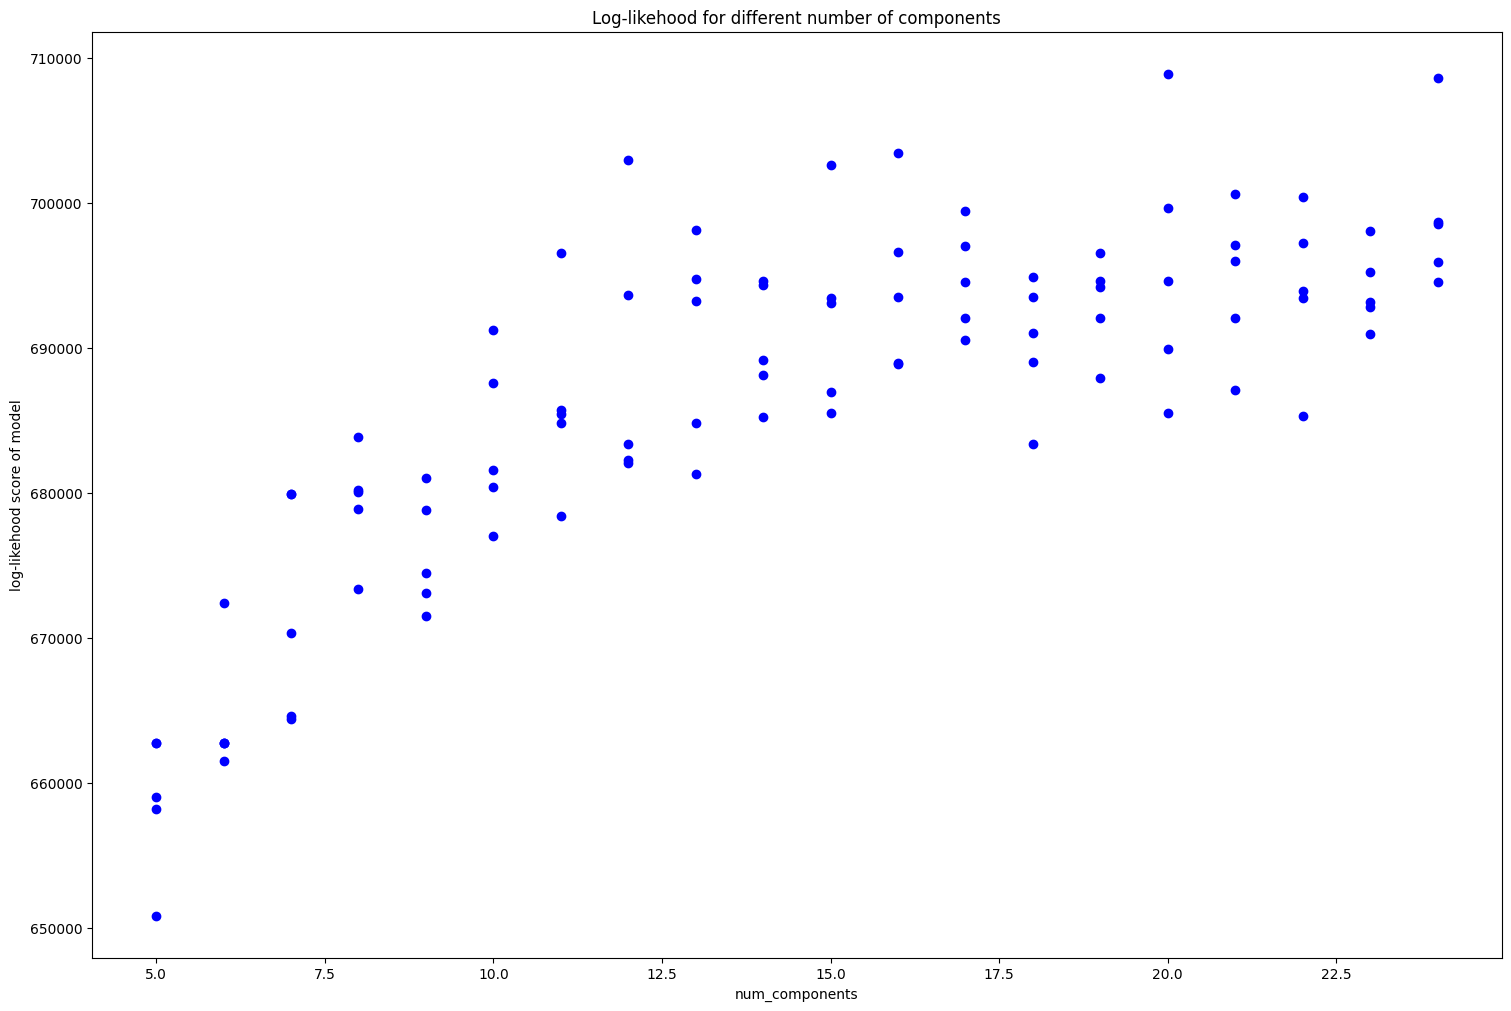

In [183]:
scores_fig = plot_model_scores(all_models)
scores_fig[0].savefig('all_model_scores_no_normalization.png', dpi=200)

In [181]:
save_to_pickles(all_models)

saved model with 5 components to pickle file
saved model with 6 components to pickle file
saved model with 7 components to pickle file
saved model with 8 components to pickle file
saved model with 9 components to pickle file
saved model with 10 components to pickle file
saved model with 11 components to pickle file
saved model with 12 components to pickle file
saved model with 13 components to pickle file
saved model with 14 components to pickle file
saved model with 15 components to pickle file
saved model with 16 components to pickle file
saved model with 17 components to pickle file
saved model with 18 components to pickle file
saved model with 19 components to pickle file
saved model with 20 components to pickle file
saved model with 21 components to pickle file
saved model with 22 components to pickle file
saved model with 23 components to pickle file
saved model with 24 components to pickle file


In [46]:
file = open('saved_models_unnormalized/model_24_components.pickle', 'rb')
best_model_24_components = pickle.load(file)
# best_model_24_components.predict_states_and_flows()
# column = '400126'
# best_model_24_components.get_predicted_flows(column, train_or_test='test')
# best_model_24_components.plot_predicted_flows(column, (0,50), train_or_test='test')

### Transition matrix learned parameters

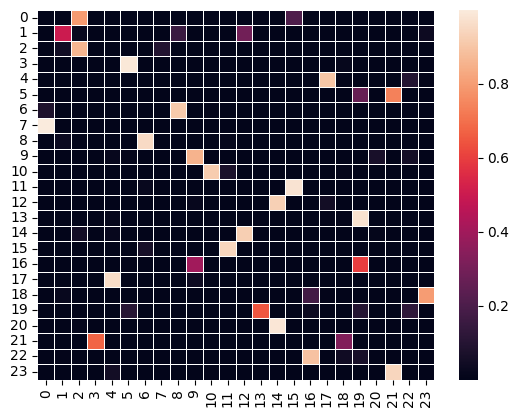

In [45]:
best_model_24_components.plot_transmat()

### Predicting (learned) average traffic flows

Here, we are predicting the traffic flow as follows. At each time step, we simply take the trained model and predict the most likely hidden state based on the observable traffic flow, and then plot the (learned) mean emission for that state in red. Rather than generating a sample from the emission distribution for the hidden state, we just plot the means in order to convey what the model's best prediction is without the Gaussian noise.

(Note: the code for these functions in the original VHMM_model class had some errors. Thus we separated the code to be outside of the class for now, just in case changing the class code would interfere with loading our previously saved model.)

In [15]:
# changed code to be outside of class, in case changing code for the class prevents loading from pickle file

col_strings_to_index = {'400126': 0,
                       '400176': 1, 
                       '400691': 2,
                       '401242': 3,
                       '401698': 4,
                       '405602': 5}

def predict_states_and_flows(VHMM_model):
    # self.model.means_ = list of means of gaussian emissions, indexed by state number
    states_and_flows = {}
    states_and_flows['predicted_states_training'] = VHMM_model.model.predict(VHMM_model.training_data, [len(VHMM_model.training_data)])
    states_and_flows['predicted_states_testing'] = VHMM_model.model.predict(VHMM_model.testing_data, [len(VHMM_model.testing_data)])
    states_and_flows['predicted_flows_training'] = [VHMM_model.model.means_[state] for state in states_and_flows['predicted_states_training']]
    states_and_flows['predicted_flows_testing'] = [VHMM_model.model.means_[state] for state in states_and_flows['predicted_states_testing']]
    return states_and_flows
    
def get_predicted_flows(states_and_flows, column, train_or_test='test'):
    """column: str, column to get predicted flows for
    train_or_test: str in {'train', 'test'}, specify which dataset to predict flows for"""
    col_index = col_strings_to_index[column]
    if train_or_test == 'train':
        predicted_mean_flows = [flow[col_index] for flow in states_and_flows['predicted_flows_training']]
        return predicted_mean_flows
    # default to predicting flows on testing data
    predicted_mean_flows = [flow[col_index] for flow in states_and_flows['predicted_flows_testing']]
    return predicted_mean_flows

def plot_predicted_flows(VHMM_model, states_and_flows, column, time_range, train_or_test='test'):
    # time_range = tuple, range of teimstesp to predict flo    
    fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
    col_index = col_strings_to_index[column]
    if train_or_test == 'training':
        selected_predicted_mean_flows = [flow[col_index] for flow in states_and_flows['predicted_flows_training'][time_range[0]:time_range[1]]]
        actual_flows = raw_df[column].tolist()[time_range[0]:time_range[1]]
    else:
        selected_predicted_mean_flows = [flow[col_index] for flow in states_and_flows['predicted_flows_testing'][time_range[0]:time_range[1]]]
        actual_flows = raw_df[column].tolist()[len(VHMM_model.training_data)+time_range[0]:len(VHMM_model.training_data)+time_range[1]]
    ax.plot(selected_predicted_mean_flows, color='red', label='predicted traffic flow means')
    ax.plot(actual_flows, color='blue', label='actual traffic flows')
    ax.set_xlabel('time')
    ax.set_ylabel('traffic flow')
    ax.set_title("Traffic flow predictions on segment " + str(column))
    ax.legend()
    return fig, ax

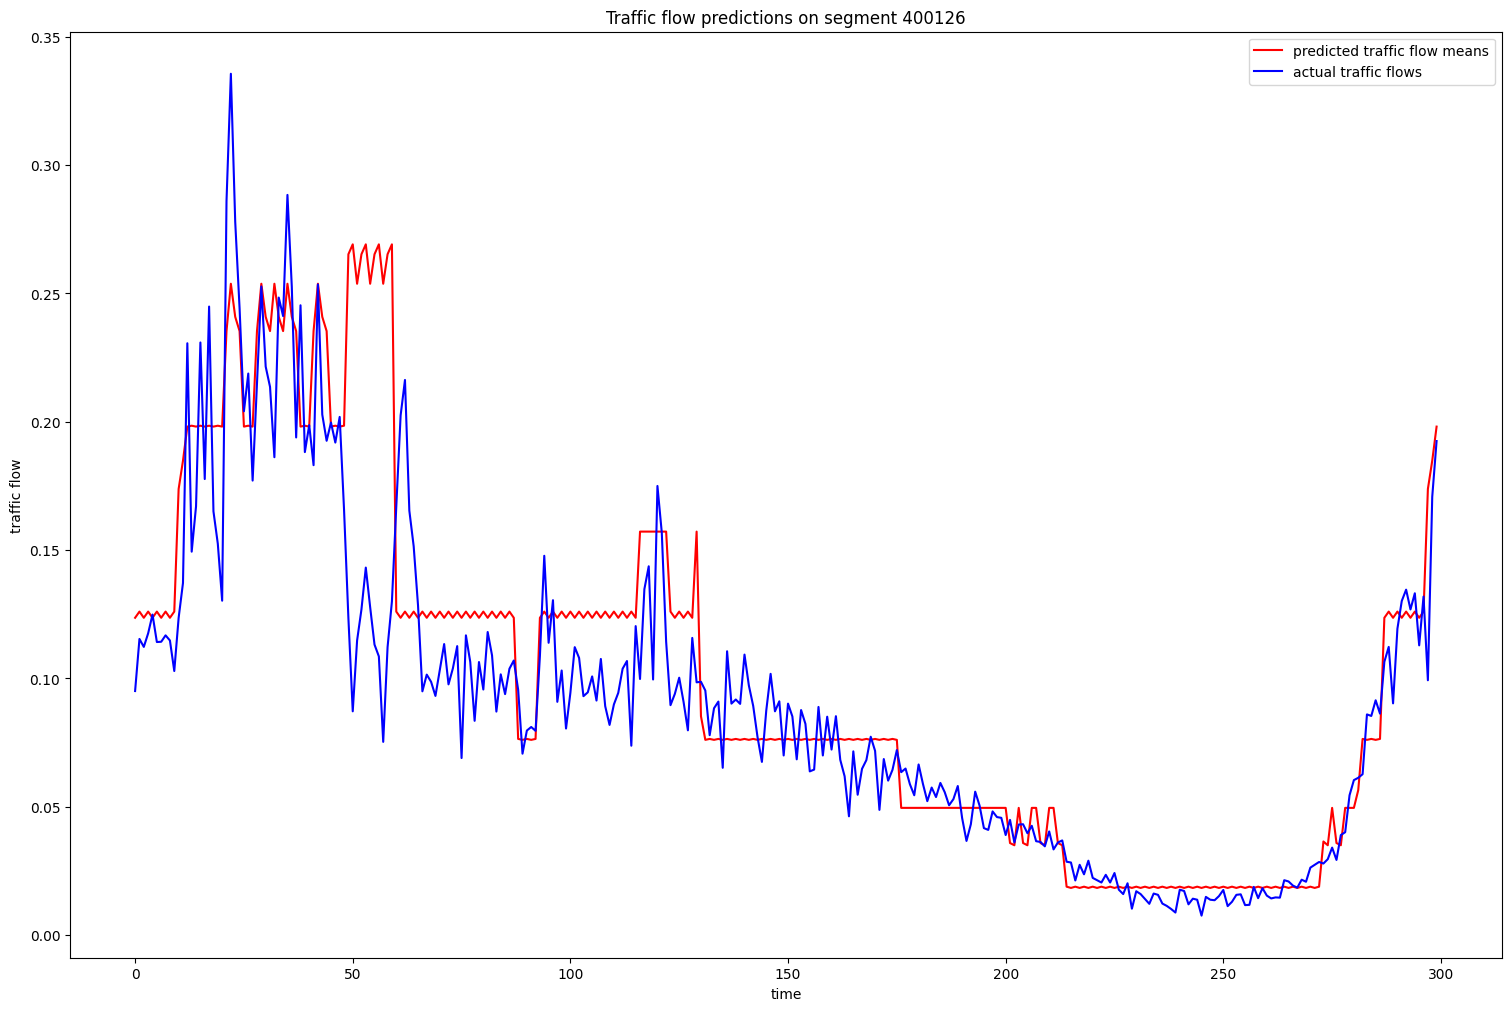

In [37]:
states_and_flows_24 = predict_states_and_flows(best_model_24_components)
predicted_flows = get_predicted_flows(states_and_flows_24, column = '400126')
# print(predicted_flows)
predicted_flows_fig = plot_predicted_flows(best_model_24_components, states_and_flows_24, '400126', (0, 300))
predicted_flows_fig[0].savefig('flow_predictions_0_steps.png', dpi=200)

Even though the flow predictions look pretty good, I don't think the performance is particularly surprising. Basically, the 4D actual traffic flows have been split into 24 different states, and each state's mean (for the HMM gaussian emission) is just the mean of the traffic flows that have in that state. Here, the predictions (projected onto one dimension, aka one road segment) sortof just look like a mellowed-out / averaged version of the actual flows. 

### Long term flow forecasting

Next, we evaluate the long-term forecasting abilities of our HMMs. The way that we are forecasting is as follows. Suppose we are forecasting n_steps ahead. In order to predict the traffic flow at time n(delta), where delta is the length of our timestep (here 5 minutes), we first use the trained model to predict the mostly likley hidden state of traffic at time (n-n_steps)(delta) based on the observable traffic flow. Then we obtain a predicted hidden state at time n(delta) by simulating n_steps of the learned Markov chain from the predicted state at time (n-n_steps)(delta). Finally, we generate a sample from the predicted hidden state at time n(delta) based on the learned (gaussian) emission distribution for that state.

In [16]:
def plot_forecasted_flows(VHMM_model, states_and_flows, column, n_steps, time_range, train_or_test='test'):
    # use predicted hidden states from n_steps before the time_range
    forecasted_flows = []
    col_index = col_strings_to_index[column]
    assert time_range[0] >= n_steps, "starting time must be larger than number of steps forward n_steps"
    states_time_range = (time_range[0] - n_steps, time_range[1] - n_steps)
    if train_or_test=='train':
        seed_states = states_and_flows['predicted_states_training'][states_time_range[0]:states_time_range[1]]
    else:
        seed_states = states_and_flows['predicted_states_testing'][states_time_range[0]:states_time_range[1]]
    for state in seed_states: # simulate n_steps of the markov chain from each seed state
        flow_samples, state_sequence = VHMM_model.model.sample(n_samples=n_steps, random_state=None, currstate=None)
        forecasted_flows.append(flow_samples[-1][col_index])
        
    if train_or_test == 'training':
        actual_flows = raw_df[column].tolist()[time_range[0]:time_range[1]]
    else:
        actual_flows = raw_df[column].tolist()[len(VHMM_model.training_data)+time_range[0]:len(VHMM_model.training_data)+time_range[1]]
    
    fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
    ax.plot(forecasted_flows, color='red', label='forecasted traffic flow means')
    ax.plot(actual_flows, color='blue', label='actual traffic flows')
    ax.set_xlabel('time')
    ax.set_ylabel('traffic flow')
    ax.set_title("Traffic flow forecasts on segment " + str(column))
    ax.legend()
    return fig, ax, forecasted_flows    

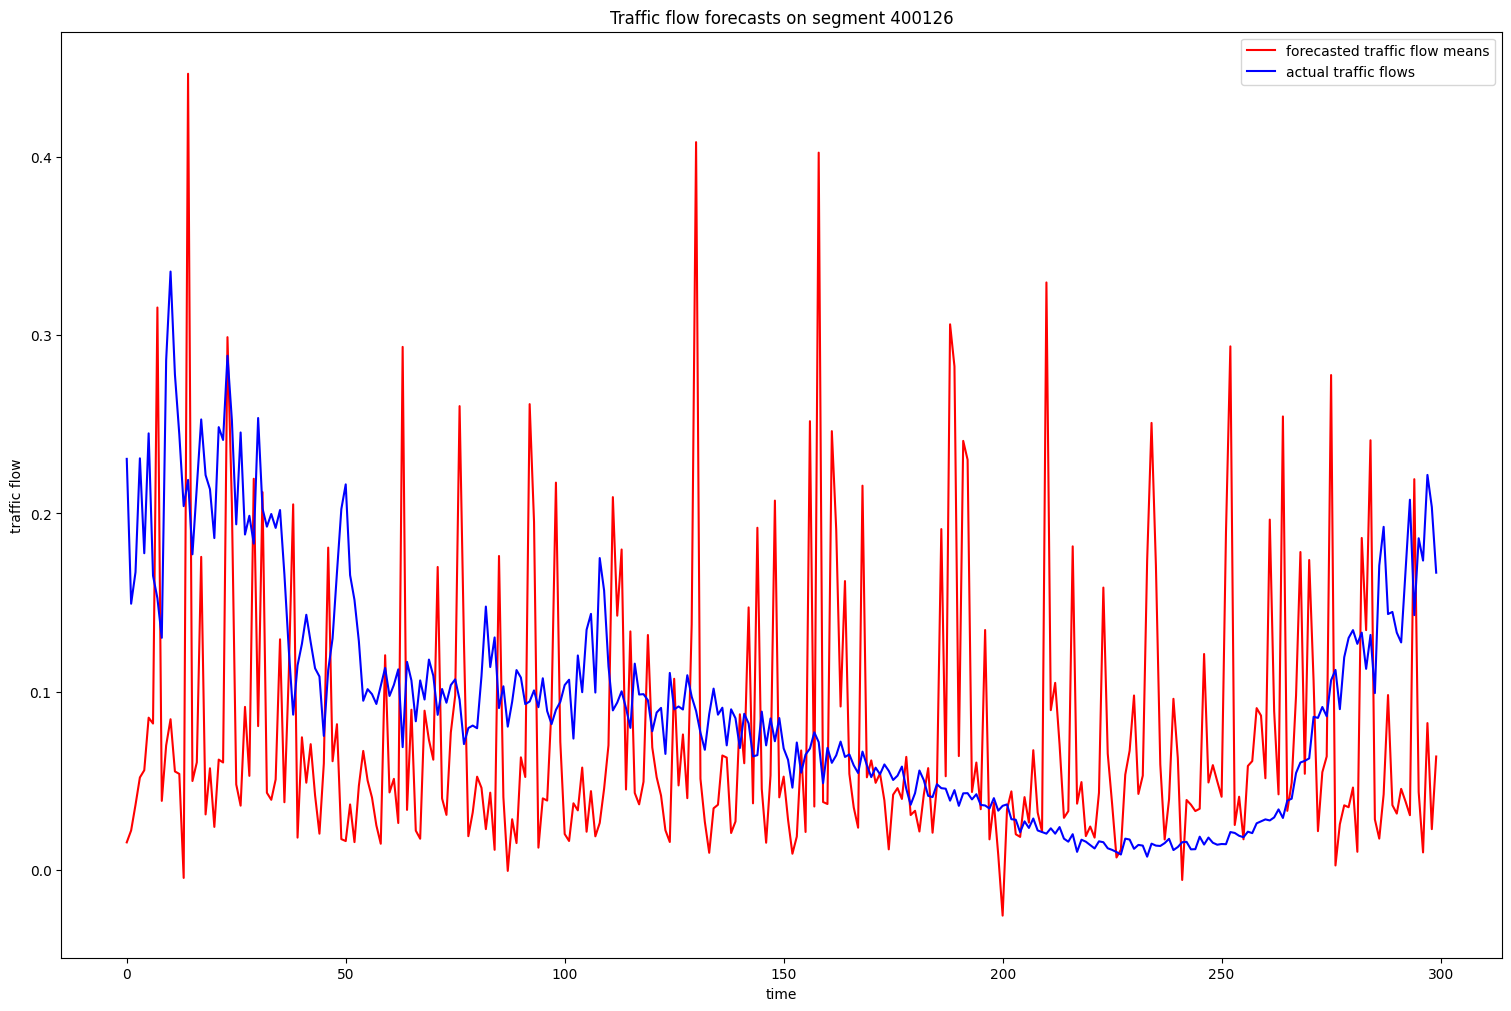

In [96]:
# predict 30m ahead (6 steps of 5 minute intervals)
forecasted_flows_fig, forecasted_flows_ax, forecasted_flows = plot_forecasted_flows(best_model_24_components, states_and_flows_24, '400126', 6, (12, 312))

In [97]:
forecasted_flows_fig.savefig('flow_predictions_30m.png', dpi=200)

The traffic flow forecasting ends up being pretty bad, even though the flows predicted from directly predicting the underlying hidden state and then plotting the (learned) means of the Gausiaan emissions was fairly accurate. This indicates that the main fault lies in the prediction of the hidden Markov chain transition probabilities; there is likely a lot of stochasticity that i.e. changes over time, or depends on the time of day, in the underlying state changes that a Markov chain does not capture with fixed transition probabilities. Furthermore, a Markov chain's transition only depends on the current state, but it seems like traffic flow in real life should depend on more previous states. It is also interesting that, especially if the transition matrix is ergodic (i.e. the graph on states is strongly connected), then after many steps in the Markov chain, we would reach some sort of stationary distribution over the states. However, again this seems unaligned with the real world, in which the distribution over traffic states should not be independent of the previous states that come before it (and for example, time of day as well).

## Models trained on Normalized data

In [47]:
# normalized
selected_cols = ['400126','400176','400691','401242']
normalized_models = train_all_models(multiplicity=5, num_components_range=(5,25), covar_type="full", columns=selected_cols, train_test_split=0.7, normalize=True) 

done training model 0 with 5 components 
score = -209785.9389953427 
current time = 02:01:11 
-------------
done training model 1 with 5 components 
score = -203589.61416153607 
current time = 02:01:56 
-------------
done training model 2 with 5 components 
score = -211227.928402923 
current time = 02:02:41 
-------------
done training model 3 with 5 components 
score = -220175.613003126 
current time = 02:03:25 
-------------
done training model 4 with 5 components 
score = -210382.20148989596 
current time = 02:04:08 
-------------
done training all models with 5 components 
------------- 
------------- 

done training model 0 with 6 components 
score = -205045.80084595393 
current time = 02:05:02 
-------------
done training model 1 with 6 components 
score = -199993.50008801455 
current time = 02:05:55 
-------------
done training model 2 with 6 components 
score = -201691.97062429777 
current time = 02:06:49 
-------------
done training model 3 with 6 components 
score = -206376.0

done training model 1 with 18 components 
score = -175462.18058521938 
current time = 04:32:37 
-------------
done training model 2 with 18 components 
score = -180438.21537435835 
current time = 04:37:02 
-------------
done training model 3 with 18 components 
score = -175179.98817939093 
current time = 04:41:34 
-------------
done training model 4 with 18 components 
score = -176372.46775070846 
current time = 04:46:07 
-------------
done training all models with 18 components 
------------- 
------------- 

done training model 0 with 19 components 
score = -179293.86003634552 
current time = 04:51:05 
-------------
done training model 1 with 19 components 
score = -177078.08153080105 
current time = 04:56:05 
-------------
done training model 2 with 19 components 
score = -176929.18965951202 
current time = 05:01:07 
-------------
done training model 3 with 19 components 
score = -174340.3244555325 
current time = 05:06:04 
-------------
done training model 4 with 19 components 
sco

In [48]:
print(normalized_models)

{5: [<__main__.VHMM_Model object at 0x130752bb0>, <__main__.VHMM_Model object at 0x13073f040>, <__main__.VHMM_Model object at 0x14221fbb0>, <__main__.VHMM_Model object at 0x1424363d0>, <__main__.VHMM_Model object at 0x13073fb20>], 6: [<__main__.VHMM_Model object at 0x141e92040>, <__main__.VHMM_Model object at 0x13073fc10>, <__main__.VHMM_Model object at 0x13073fd00>, <__main__.VHMM_Model object at 0x13073fca0>, <__main__.VHMM_Model object at 0x13073f280>], 7: [<__main__.VHMM_Model object at 0x141e92130>, <__main__.VHMM_Model object at 0x13073f760>, <__main__.VHMM_Model object at 0x142194580>, <__main__.VHMM_Model object at 0x13073f850>, <__main__.VHMM_Model object at 0x13073f6a0>], 8: [<__main__.VHMM_Model object at 0x13073fc70>, <__main__.VHMM_Model object at 0x13073fa60>, <__main__.VHMM_Model object at 0x1307522b0>, <__main__.VHMM_Model object at 0x130752ee0>, <__main__.VHMM_Model object at 0x130752dc0>], 9: [<__main__.VHMM_Model object at 0x14222b370>, <__main__.VHMM_Model object at

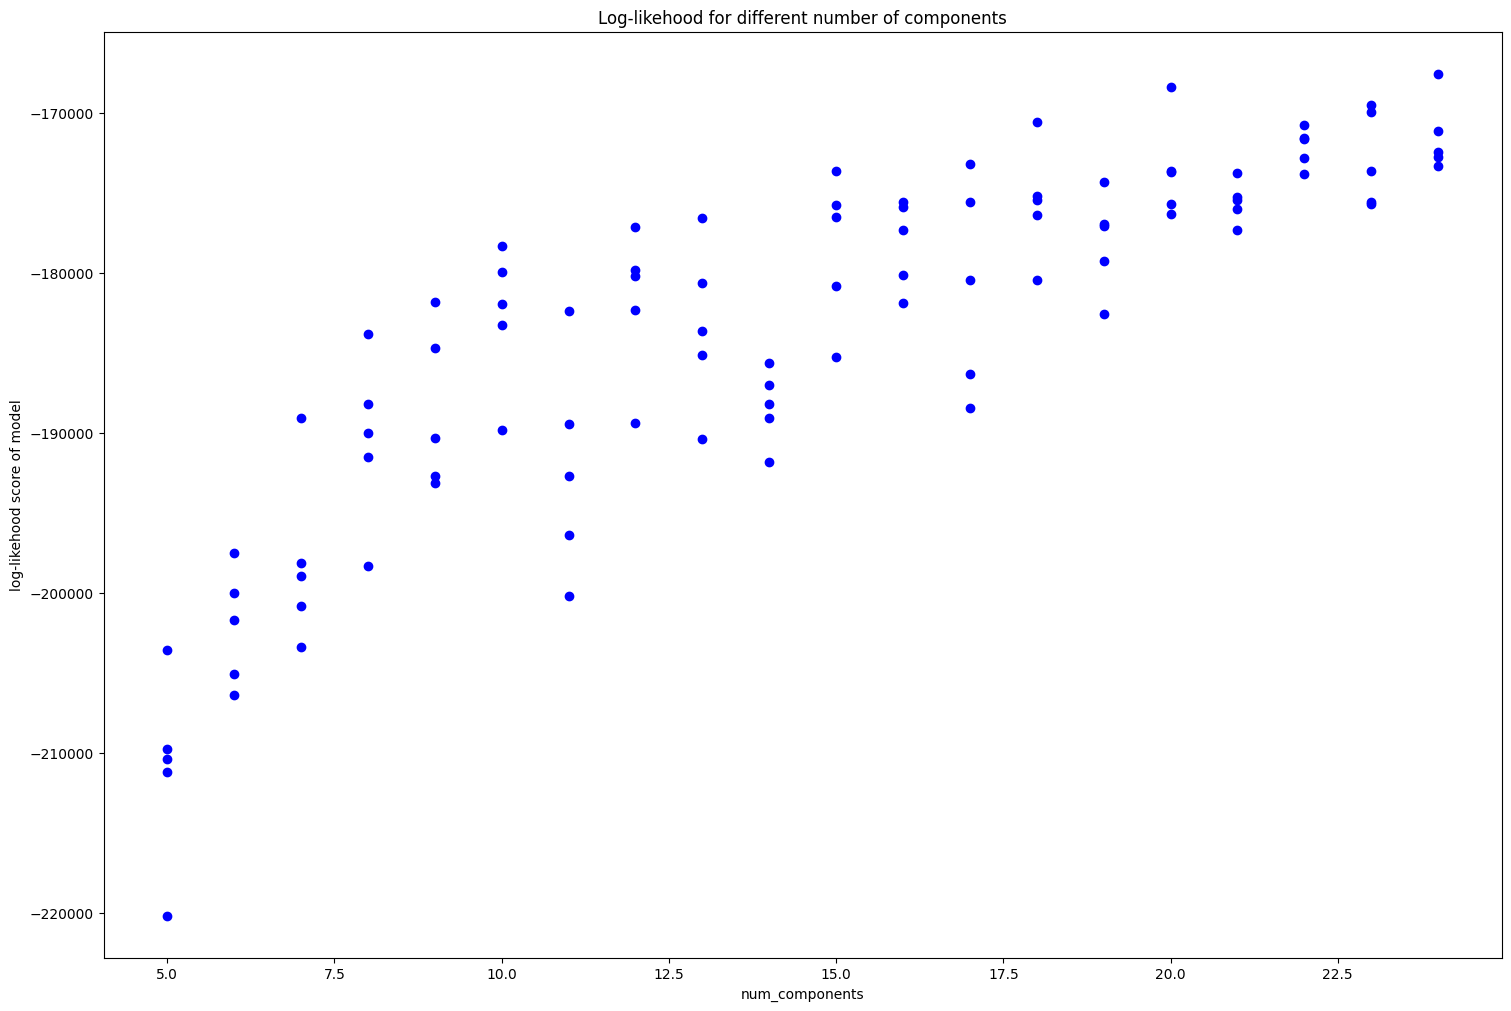

In [50]:
scores_fig = plot_model_scores(normalized_models)
scores_fig[0].savefig('all_model_scores_normalization.png', dpi=200)

The normalized models also have an increase in score with number of models, and furthermore the rate increase does not seem to decrease as quickly (the second derivative seems less negative) - even around 24 components, it seems like the average performance is still increasing linearly, which is promising. However, the scores themselves are negative and much smaller than the log likelihoods of the unnormalized models. For example, the model with 24 components has a log-likelihood score around -170000 here, compared to the log-likelihood of 710000 for the unnormalized models.

In [51]:
save_to_pickles(normalized_models, normalized=True)

saved model with 5 components to pickle file
saved model with 6 components to pickle file
saved model with 7 components to pickle file
saved model with 8 components to pickle file
saved model with 9 components to pickle file
saved model with 10 components to pickle file
saved model with 11 components to pickle file
saved model with 12 components to pickle file
saved model with 13 components to pickle file
saved model with 14 components to pickle file
saved model with 15 components to pickle file
saved model with 16 components to pickle file
saved model with 17 components to pickle file
saved model with 18 components to pickle file
saved model with 19 components to pickle file
saved model with 20 components to pickle file
saved model with 21 components to pickle file
saved model with 22 components to pickle file
saved model with 23 components to pickle file
saved model with 24 components to pickle file


In [52]:
file = open('saved_models_normalized/normalized_model_24_components.pickle', 'rb')
best_normalized_model_24_components = pickle.load(file)

In [ ]:
selected_cols = ['400126','400176','400691','401242']
# aperiodic_data.dataframe is equiv to raw_df on normalized data

In [37]:
# add normalization (blue traffic flow graph should also be of normalized data)

def plot_predicted_flows_add_normalization(VHMM_model, states_and_flows, column, time_range, train_or_test='test', normalized=True):
    # time_range = tuple, range of timestep to predict flo    
    fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
    col_index = col_strings_to_index[column]
    if train_or_test == 'training':
        selected_predicted_mean_flows = [flow[col_index] for flow in states_and_flows['predicted_flows_training'][time_range[0]:time_range[1]]]
        if not normalized:
            actual_flows = raw_df[column].tolist()[time_range[0]:time_range[1]]
        else:
            actual_flows = aperiodic_data.dataframe[column].tolist()[time_range[0]:time_range[1]]
    else:
        selected_predicted_mean_flows = [flow[col_index] for flow in states_and_flows['predicted_flows_testing'][time_range[0]:time_range[1]]]
        if not normalized:
            actual_flows = raw_df[column].tolist()[len(VHMM_model.training_data)+time_range[0]:len(VHMM_model.training_data)+time_range[1]]
        else:
            actual_flows = aperiodic_data.dataframe[column].tolist()[len(VHMM_model.training_data)+time_range[0]:len(VHMM_model.training_data)+time_range[1]]
    ax.plot(selected_predicted_mean_flows, color='red', label='predicted traffic flow means')
    ax.plot(actual_flows, color='blue', label='actual traffic flows (normalized)')
    ax.set_xlabel('time')
    ax.set_ylabel('traffic flow (normalized)')
    ax.set_title("Normalized traffic flow predictions on segment " + str(column))
    ax.legend()
    return fig, ax

def plot_forecasted_flows_add_normalization(VHMM_model, states_and_flows, column, n_steps, time_range, train_or_test='test', normalized=True):
    # use predicted hidden states from n_steps before the time_range
    forecasted_flows = []
    col_index = col_strings_to_index[column]
    assert time_range[0] >= n_steps, "starting time must be larger than number of steps forward n_steps"
    states_time_range = (time_range[0] - n_steps, time_range[1] - n_steps)
    if train_or_test=='train':
        seed_states = states_and_flows['predicted_states_training'][states_time_range[0]:states_time_range[1]]
    else:
        seed_states = states_and_flows['predicted_states_testing'][states_time_range[0]:states_time_range[1]]
    for state in seed_states: # simulate n_steps of the markov chain from each seed state
        flow_samples, state_sequence = VHMM_model.model.sample(n_samples=n_steps, random_state=None, currstate=None)
        forecasted_flows.append(flow_samples[-1][col_index])
        
    if train_or_test == 'train':
        if not normalized:
            actual_flows = raw_df[column].tolist()[time_range[0]:time_range[1]]
        else:
            actual_flows = aperiodic_data.dataframe[column].tolist()[time_range[0]:time_range[1]]
    else:
        if not normalized:
            actual_flows = raw_df[column].tolist()[len(VHMM_model.training_data)+time_range[0]:len(VHMM_model.training_data)+time_range[1]]
        else:
            actual_flows = aperiodic_data.dataframe[column].tolist()[len(VHMM_model.training_data)+time_range[0]:len(VHMM_model.training_data)+time_range[1]]
    
    fig, ax = plt.subplots(figsize=(15, 10), layout='constrained')
    ax.plot(forecasted_flows, color='red', label='forecasted traffic flow means')
    ax.plot(actual_flows, color='blue', label='actual traffic flows (normalized)')
    ax.set_xlabel('time')
    ax.set_ylabel('traffic flow (normalized)')
    ax.set_title("Normalized Traffic flow forecasts on segment " + str(column))
    ax.legend()
    return fig, ax, forecasted_flows  

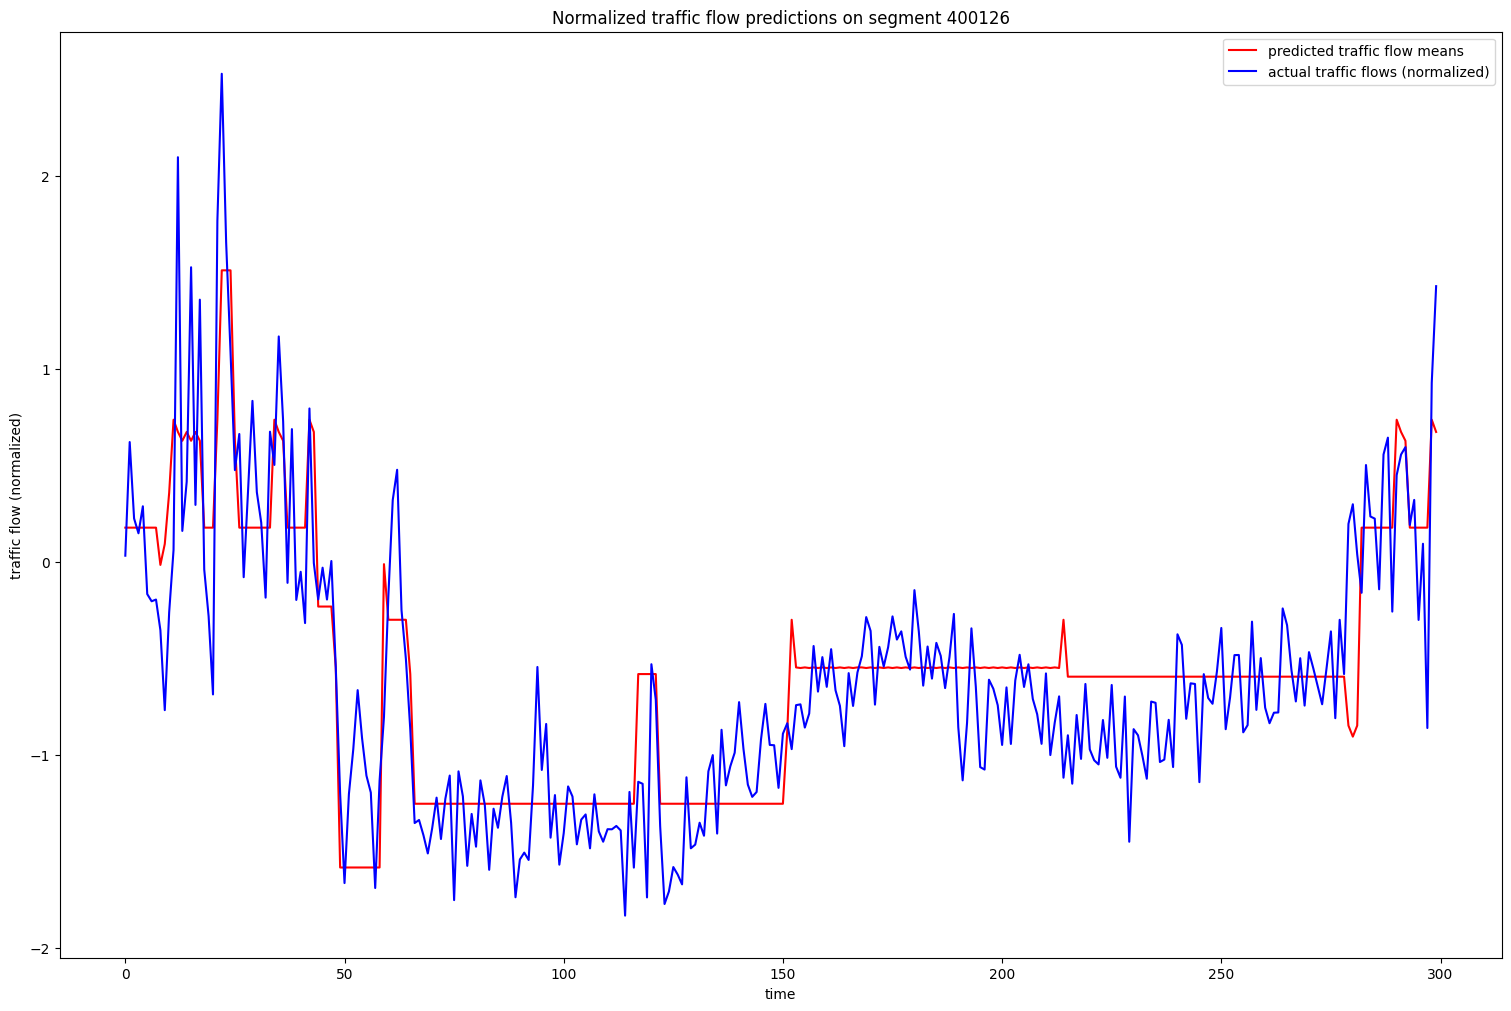

In [54]:
states_and_flows_24_normalized = predict_states_and_flows(best_normalized_model_24_components)
predicted_flows_normalized = get_predicted_flows(states_and_flows_24_normalized, column = '400126')
# print(predicted_flows)
predicted_flows_fig = plot_predicted_flows_add_normalization(best_normalized_model_24_components, states_and_flows_24_normalized, '400126', (0, 300), train_or_test='test')
predicted_flows_fig[0].savefig('normalized_flow_predictions_0_steps_raw.png', dpi=200)

The predicted flows for the 24-component model trained on normalized data look much better than the unnormalized mean predictions. Namely, there are no more erratic jumps in the traffic flow around time 50, and it seems like generally the states/means for each state are more smooth.

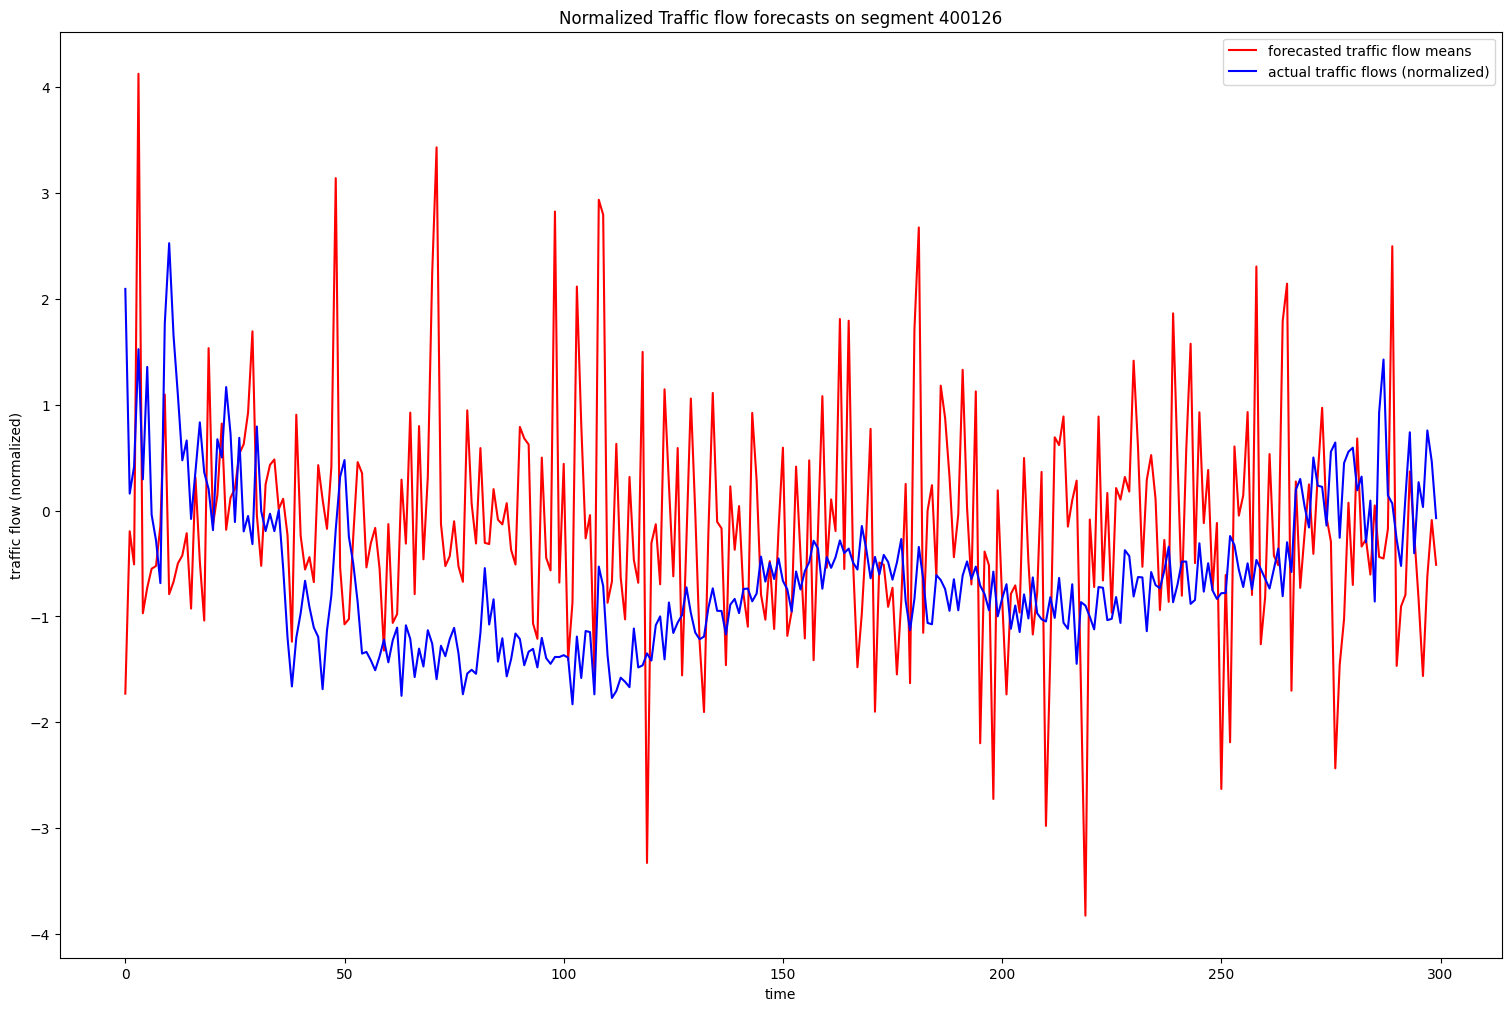

In [55]:
# predict 30m ahead (6 steps of 5 minute intervals)
forecasted_flows_fig, forecasted_flows_ax, forecasted_flows = plot_forecasted_flows_add_normalization(best_normalized_model_24_components, states_and_flows_24_normalized, '400126', 6, (12, 312))
forecasted_flows_fig.savefig('normalized_flow_predictions_30m_raw.png', dpi=200)

Normalization does not help much in terms of forecasting flows but the overall arc of the flows seems to actually contain some shape? idk

In [ ]:
# plt.plot(xdata, ydata, 'or')
# plt.plot(xfit, yfit, '-', color='gray')
# plt.fill_between(xfit, yfit - dyfit, yfit + dyfit, color='gray', alpha=0.2)
# plt.xlim(0, 10);

# OLD STUFF

In [125]:
ax = sns.heatmap(best_model.model.transmat_, linewidth=0.5)
plt.show()

array([[9.31445925e-01, 2.76382887e-06, 2.76382887e-06, 2.76382887e-06,
        2.76382887e-06, 2.76382887e-06, 8.18298049e-03, 2.76382887e-06,
        6.42895373e-03, 2.76382887e-06, 2.76382898e-06, 4.85187038e-02,
        2.76382887e-06, 2.76382887e-06, 2.76382887e-06, 2.76382889e-06,
        2.76382887e-06, 2.76382887e-06, 2.76382890e-06, 2.76382888e-06,
        2.76382887e-06, 2.76382889e-06, 5.37092398e-03, 2.76382887e-06],
       [6.12078298e-03, 2.61741349e-06, 5.01245563e-04, 2.61741349e-06,
        4.70619073e-02, 2.61741350e-06, 2.61741349e-06, 2.61741350e-06,
        2.61741349e-06, 2.61741350e-06, 2.61741349e-06, 2.61741350e-06,
        2.61741349e-06, 2.61741349e-06, 2.61741350e-06, 7.13671263e-04,
        2.25486698e-01, 2.61741349e-06, 2.61741349e-06, 2.61741349e-06,
        7.20068581e-01, 2.61741349e-06, 2.61741350e-06, 2.61741349e-06],
       [2.43014313e-03, 2.43435085e-06, 8.57537535e-01, 2.43435085e-06,
        2.43435085e-06, 2.43435091e-06, 4.85319707e-03, 2.4343

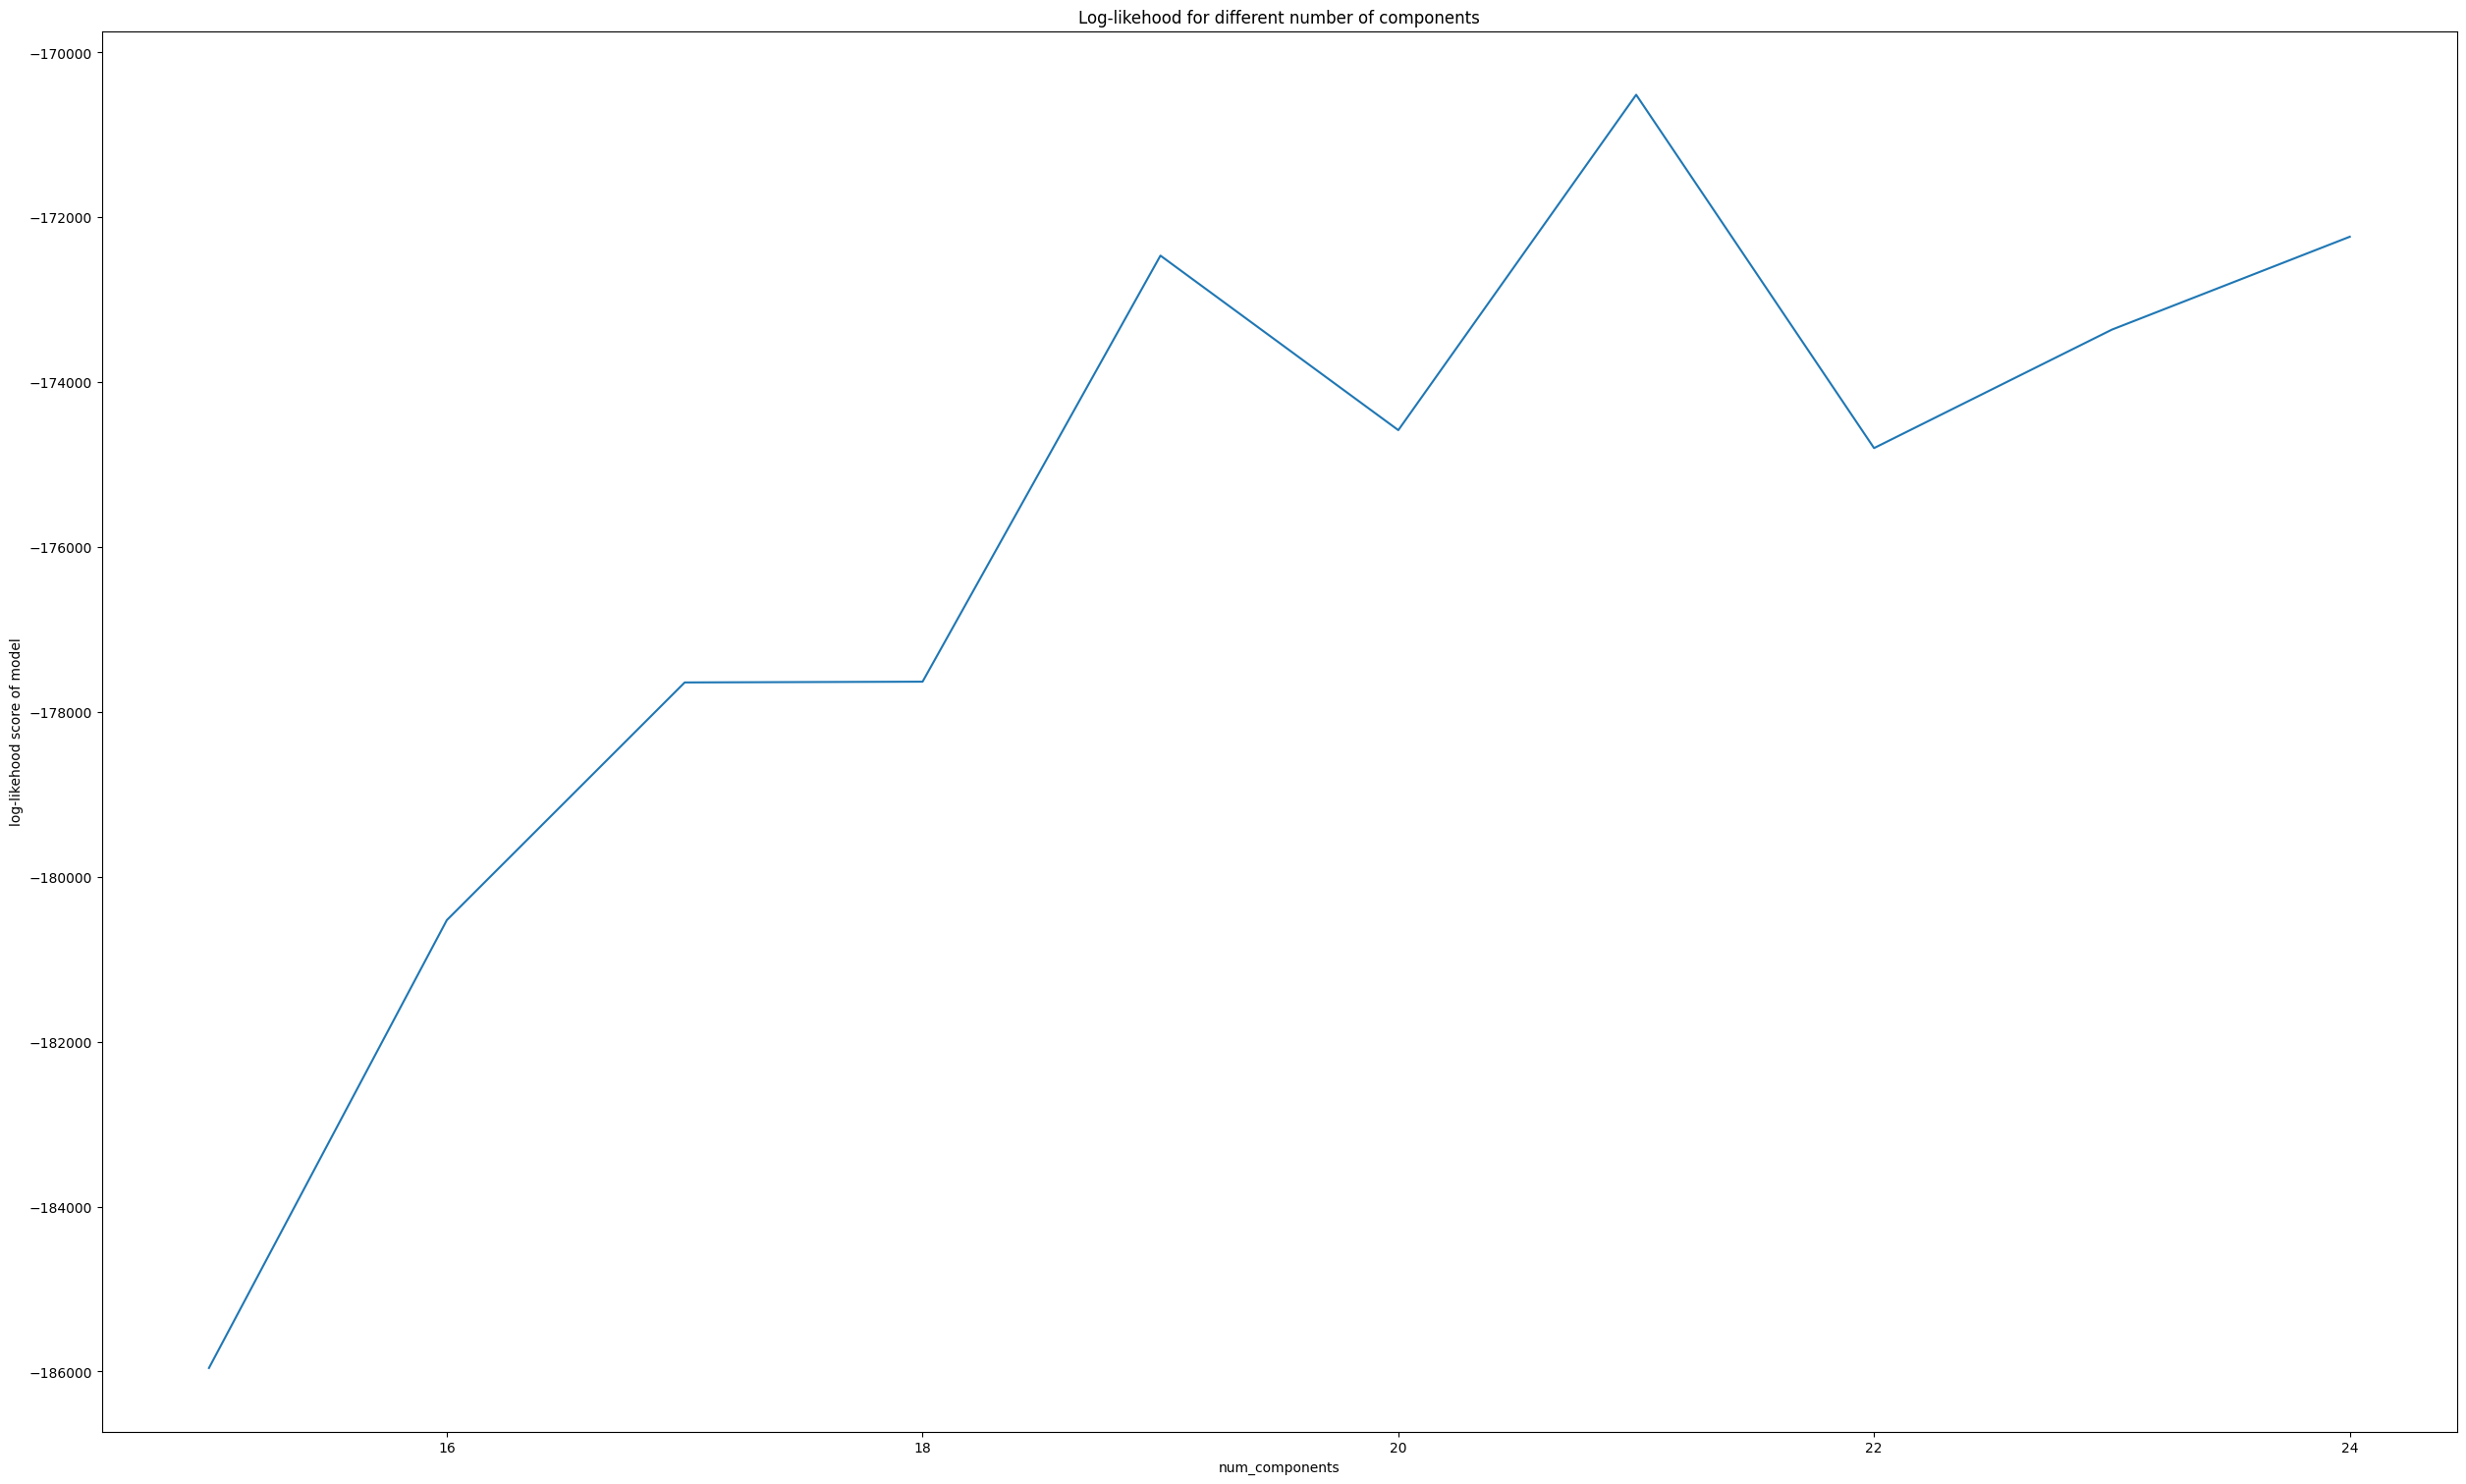

In [108]:
plot_model_scores(all_models_normalized)

[OLD]
Below we plot the direct traffic flow predictions (see previous graph 'Traffic flow predictions on segment 400126') of a single 24-component model trained on normalized data. We can see that at least for the first 50 timesteps, the difference in accuracy is not huge (24-component models were already pretty accurate on unnormalized data). 

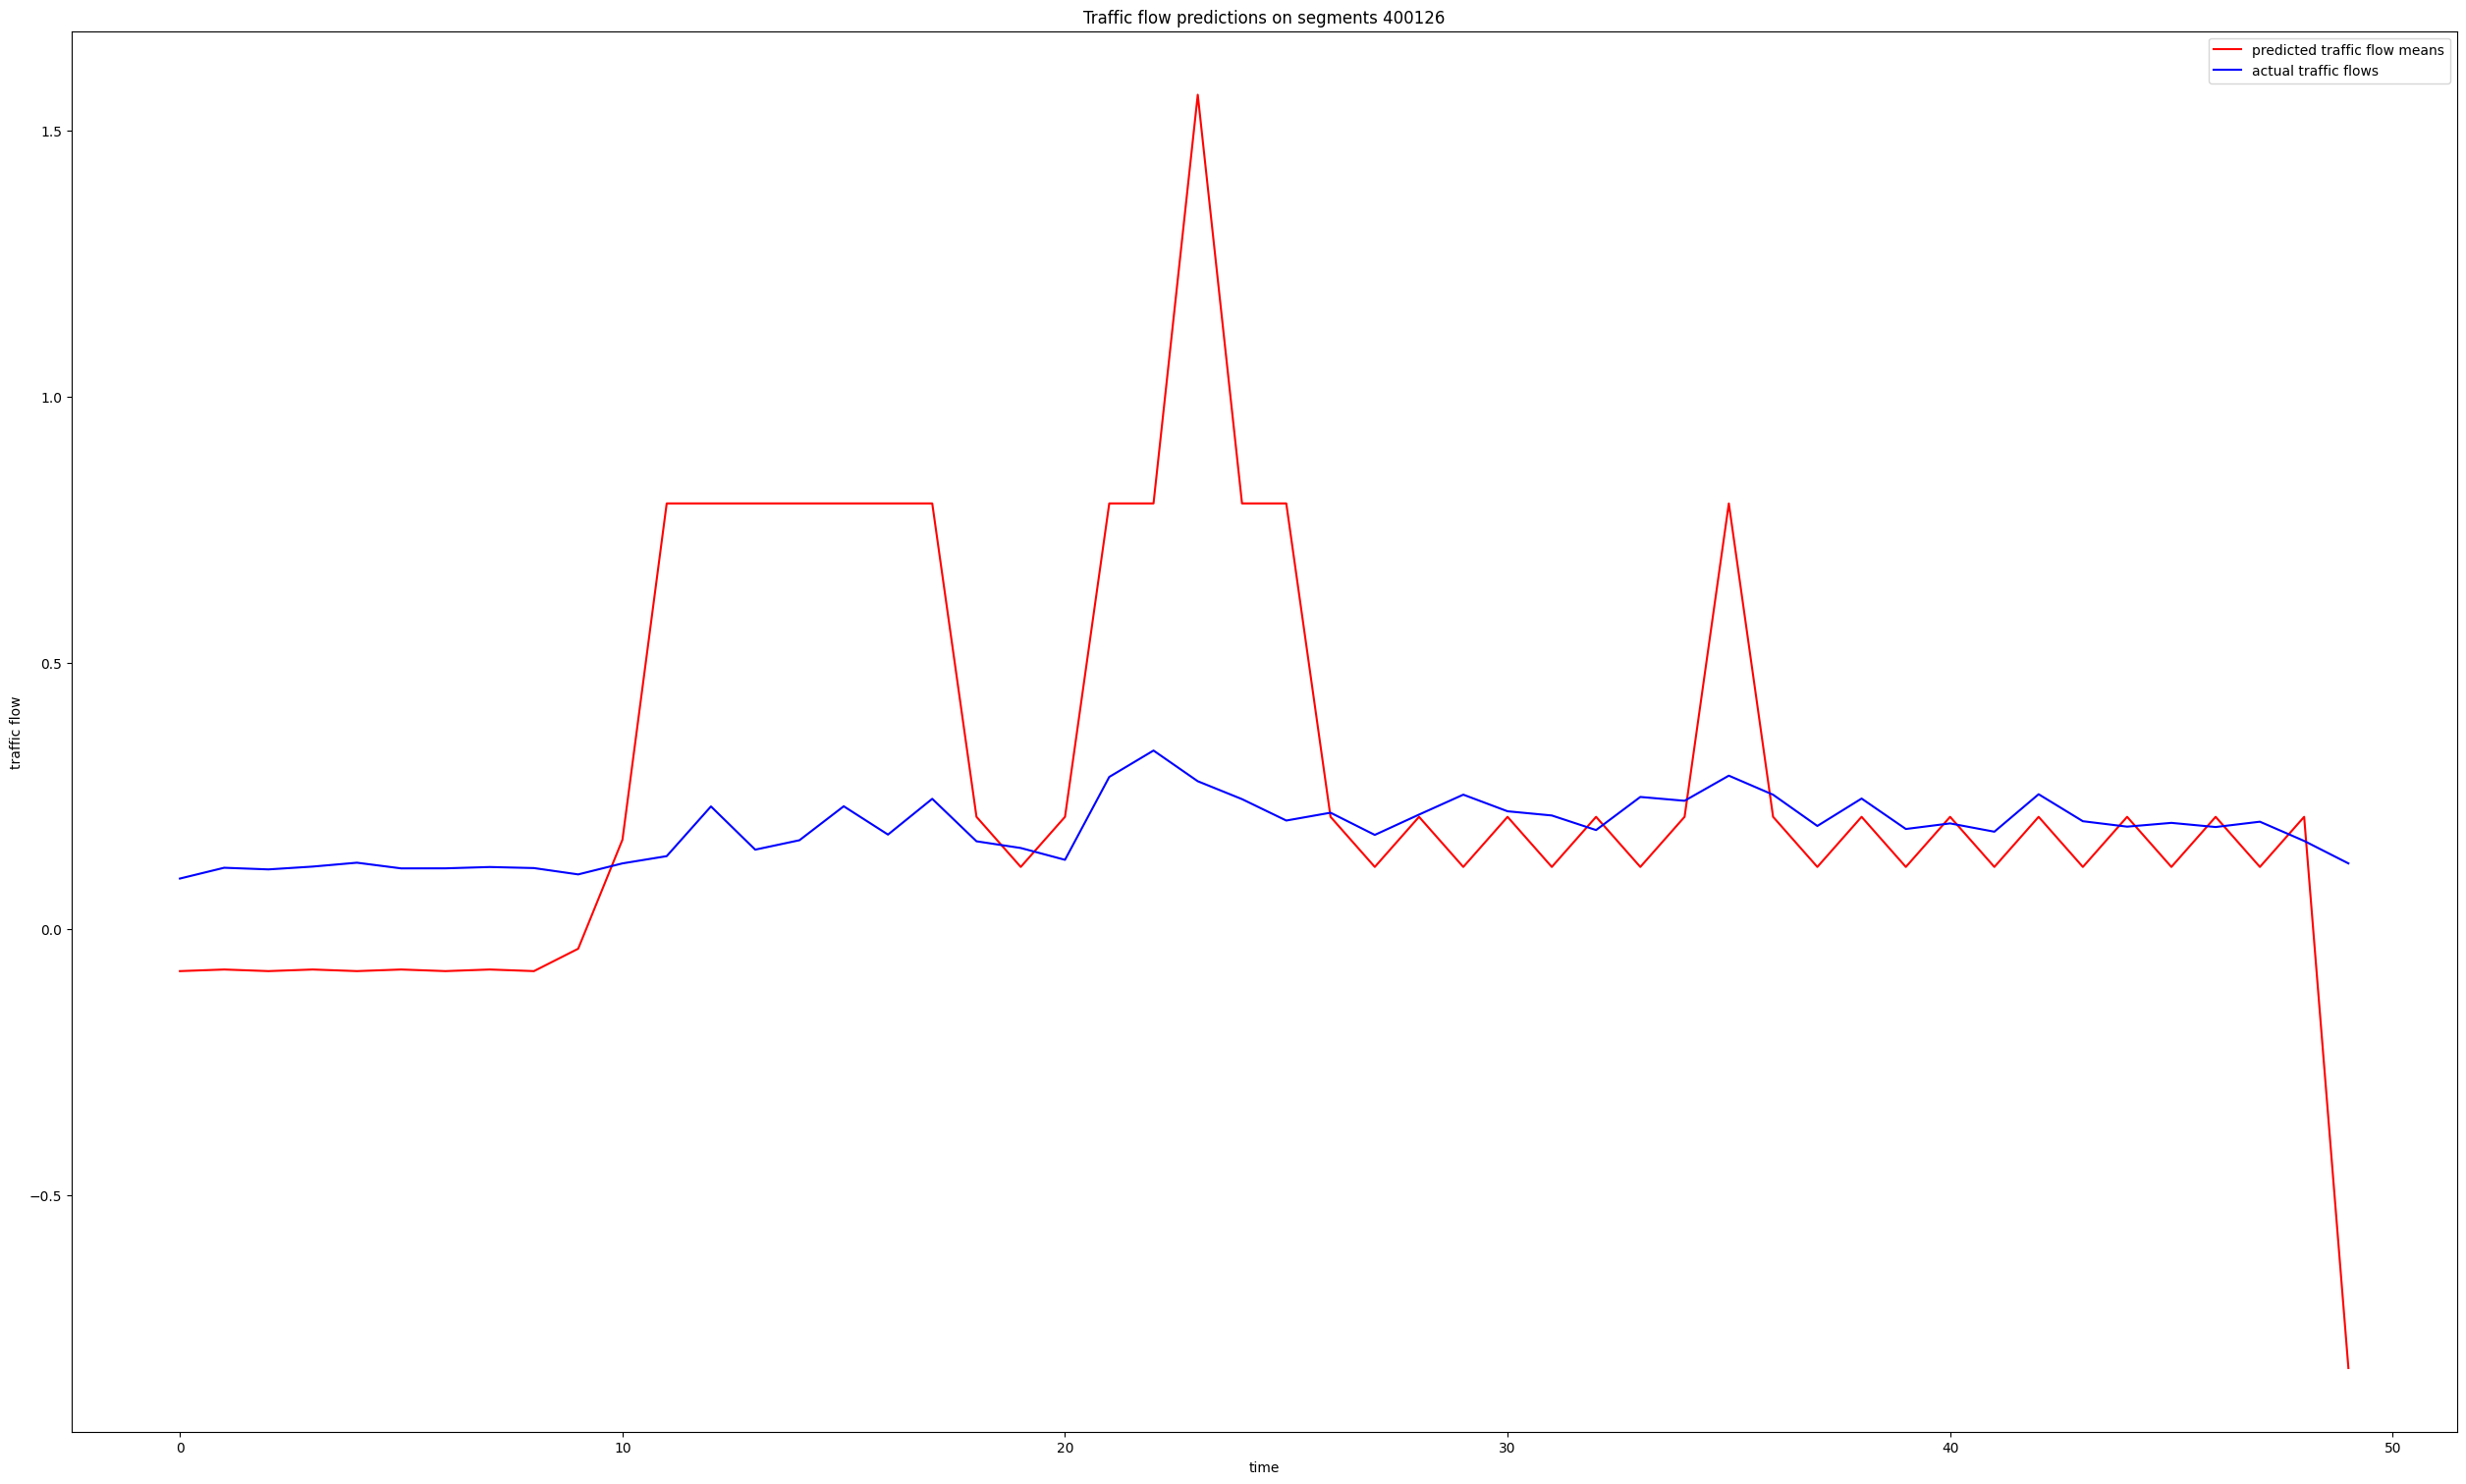

In [118]:
best_model_normalized = all_models_normalized[24]
best_model_normalized.predict_states()
predicted_flows = best_model_normalized.get_predicted_flows('400126')
plot_predicted_flows('400126', predicted_flows, 50)

[OLD]
Below we plot a heatmap of the transition matrix for a 24-component model trained on unnormalized data.

We note that the transition matrix is incredibly sparse - most of the parameters are close to 0. this is telling us that making the state space and thus transition matrix higher dimensional is probably not really helping us encode more information. rather, perhaps we should rely on a linear dynamical system with less parameters. a further advantage of LDS would be that the # of parameters scales with dimensionality of underlying space, not the number of hidden states, and thus we could still get essentially infinite hidden states while having to learn less parameters.

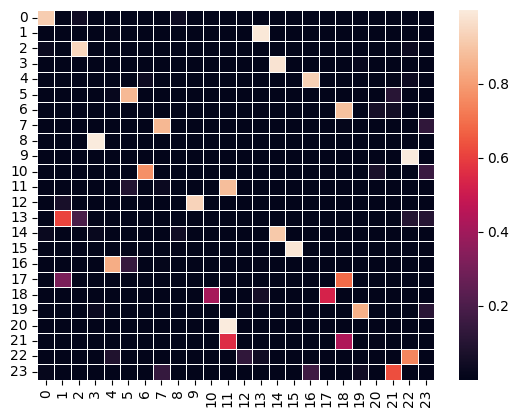

In [63]:
# plotting the transition matrix
import seaborn as sns
ax = sns.heatmap(transmat, linewidth=0.5)
plt.show()

# Ongoing notes/next steps

some notes about future models:
- means plot is not actually a prediction question, just another way of evaluating the model on observed 
- forecasting 2 hours ahead - basically simulate the trained model on the e.g. 30m before the 
    - compare # of components vs. forecasting ability
- benchmark against non-parametric models (NNs, SGDs, random forests)
- try using linear dynamical system model (basically hidden markov model, except hidden states evolve according to a fixed linear transformation at each time step with the addition of some small gaussian noise)
- look into perhaps models that allow more custom specification of underlying hidden states - perhaps discrete sets of continuous spaces? where one space corresponds to traffic flow evolution during no incidents, the other corresponds to incidents


combining HMM with linear regression 'emissions'
- most important next step: evaluate forecasting many timesteps ahead (i.e. 1 hour = 12 timesteps)